# Imports
Imports and configurations are handled here as needed.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, recall_score, make_scorer
from sklearn.pipeline import Pipeline
from scipy.stats import ttest_rel

import warnings
warnings.filterwarnings("ignore")

# Data Preparation
Load the data from text files and preprocess it.

In [2]:
# base_path = "/blue/hcds_hackathon/hackathon_projects/lung_cancer_metabolomics/metabolite_data/"
base_path = "./data/"
data1_path = base_path + "ST000368_1.txt"
data2_path = base_path + "ST000369.txt"

In [3]:
# function to convert file to pandas dataframe
def process_data(data_path, metabolite_offset):
    with open(data_path) as f:
        lines = f.read().split("\n")

    ## the first line is patient IDs
    keys = lines[0].split("\t")
    # print(len(keys))

    ## the second line is clinical data for each patient ID (organ/cancer/smoker/gender)
    clinical_data = [x.split(" | ") for x in lines[1].split("\t")]
    clinical_data = [([y.split(":")[len(y.split(":")) - 1] for y in x]) for x in clinical_data]
    # print(len(clinical_data))

    result = dict(zip(keys, clinical_data))
    
    ## the remaining lines are metabolomics
    ## error, some lines are NA. figure out where NA should be removed when attaching metabolomics
    for n in range(2, len(lines)):
        split_metabolics = lines[n].split("\t")
        zipped = list(zip(keys, split_metabolics))
        for x in zipped:
            result[x[0]].append(x[1])

    ## remove these rows as they are column names/identifiers for metabolites and not informative 
    metabolites = result.pop("Metabolite_name")
    refmet_name = result.pop("RefMet_name")
    keys.remove("Metabolite_name")
    keys.remove("RefMet_name")

    ## create column names and generate a dataframe to return
    colnames = ["Organ", "Cancer", "Smoker", "Gender"]
    for x in metabolites[1:-1]:
        colnames.append(x)
        
    df = pd.DataFrame(result).T
    df.columns = colnames

    return df

df1 = process_data(data1_path, 2)
df2 = process_data(data2_path, 2)
combined_df = pd.concat([df1, df2])[(list(set(df1.columns) & set(df2.columns)))]

# combined_df.to_csv("metabolites.csv")
combined_df


,tocopherol alpha,oleic acid,isocitric acid,shikimic acid,Organ,glutamic acid,maleimide,proline,xanthine,nicotinic acid,...,threitol,2_3_5-trihydroxypyrazine NIST,pyruvic acid,parabanic acid NIST,paracetamol,arabinose,kynurenine,linoleic acid,glutamine,glyceric acid
140225dlvsa44_1,2091,2314,331,437,Plasma,3309,124,51773,41,133,...,212,34,2911,286,157,159,93,674,31219,724
140226dlvsa30_1,1840,2559,355,1070,Plasma,9616,1688,124165,100,83,...,413,54,148,420,511,308,189,1391,53551,2225
140226dlvsa36_1,2126,1684,285,2378,Plasma,4699,1675,76766,177,108,...,351,45,308,463,106,500,227,1631,58592,3058
140227dlvsa36_1,3125,3575,417,1843,Plasma,8510,3885,66456,125,83,...,307,107,281,448,59,294,247,2486,61009,3138
140227dlvsa47_1,1763,3325,383,2116,Plasma,12094,2688,29871,208,79,...,217,55,415,467,467,132,190,1789,48588,2735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130730dlvsa12_1,1112,2520,303,1011,Serum,4109,1472,59056,132,84,...,185,46,991,167,388,148,184,1122,40179,3752
130730dlvsa25_1,394,1583,189,814,Serum,8274,720,99980,209,114,...,459,88,2900,230,660,111,118,546,31589,1688
130730dlvsa43_1,574,586,231,370,Serum,7525,477,82526,91,42,...,303,36,2070,151,74,219,229,188,30283,1695
130730dlvsa49_1,1475,3734,239,1172,Serum,5587,1250,64509,109,213,...,382,39,831,394,99,280,205,1711,60001,3647


In [4]:
data = combined_df.copy()
data = data[data["Gender"] != "NA"]
data = data[data["Cancer"].isin(["Healthy", "Adenocarcinoma"])]

y = (data["Cancer"] == "Healthy").map({False: 1, True: 0})
X_metabolics = data.drop("Cancer", axis=1).drop(["Organ", "Smoker", "Gender"], axis=1)

X_clinical = data.drop("Cancer", axis=1).drop(["Organ"], axis=1)
X_clinical["Smoker"] = X_clinical["Smoker"].map({"Former": 0, "Current": 1})
X_clinical["Gender"] = X_clinical["Gender"].map({"F": 0, "M": 1})

def na_vals(X):
    X = X.replace("", np.nan)
    X = X.apply(pd.to_numeric)
    X = X.fillna(X.mean(numeric_only=True))
    return X

X_clinical = na_vals(X_clinical)
X_metabolics = na_vals(X_metabolics)

# Comparison of Model Performance - Clinical Data
Compare how the model performs when including clinical data and excluding clinical data.

Metabolomics only -> median accuracy: 0.598, max accuracy: 0.763, median recall: 0.623, max recall: 0.818
Clinical features -> median accuracy: 0.598, max accuracy: 0.722, median recall: 0.618, max recall: 0.820


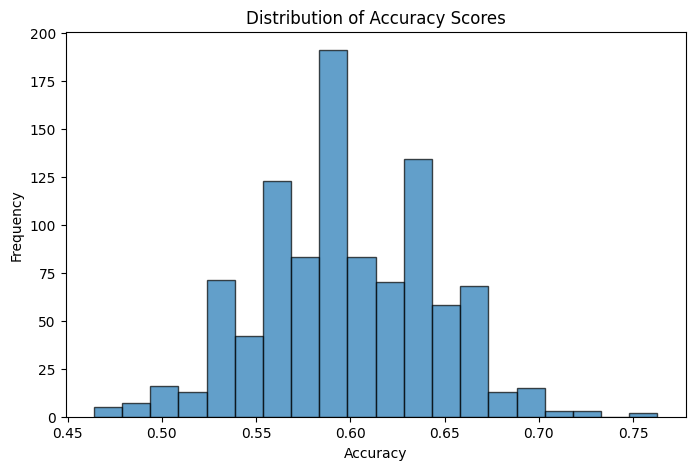

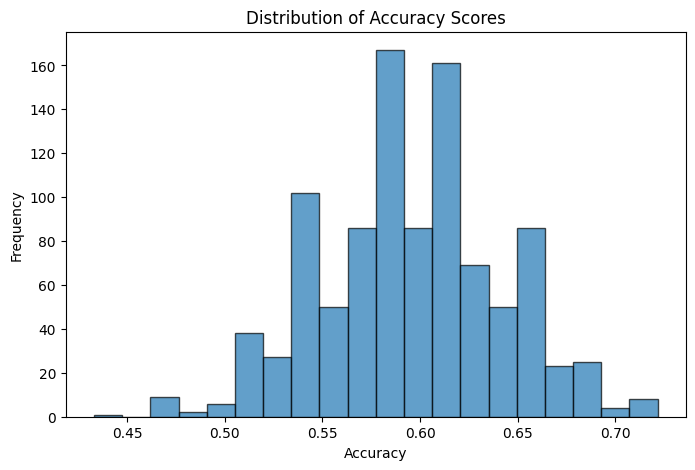

Clinical-feature accuracies are significantly higher (t=-5.126, p=0.0000)


In [5]:
scaler = StandardScaler()

count = 0
saved_model = None
prev_acc = 0

accuracy_list = []
recall_list = []
coef_list = []
acc2_list = []
recall2_list = []
coef2_list = []

while (count < 1000):
    # if (count % 1000 == 0):
    #     print(count)
    count += 1
    ## metabolics
    X_train, X_test, y_train, y_test = train_test_split(X_metabolics, y, test_size=0.3, random_state=count)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = LinearSVC(random_state=0, max_iter=5000)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    accuracy_list.append(acc)
    recall_list.append(rec)
    coef_list.append(model.coef_[0])

    ## clinical data
    X_train, X_test, y_train, y_test = train_test_split(X_clinical, y, test_size=0.3, random_state=count)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = LinearSVC(random_state=0, max_iter=5000)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    acc2_list.append(acc)
    recall2_list.append(rec)
    coef2_list.append(model.coef_[0])

met_median = np.median(accuracy_list)
met_max = np.max(accuracy_list)
met_recall_median = np.median(recall_list)
met_recall_max = np.max(recall_list)
clin_median = np.median(acc2_list)
clin_max = np.max(acc2_list)
clin_recall_median = np.median(recall2_list)
clin_recall_max = np.max(recall2_list)

print(f"Metabolomics only -> median accuracy: {met_median:.3f}, max accuracy: {met_max:.3f}, median recall: {met_recall_median:.3f}, max recall: {met_recall_max:.3f}")
print(f"Clinical features -> median accuracy: {clin_median:.3f}, max accuracy: {clin_max:.3f}, median recall: {clin_recall_median:.3f}, max recall: {clin_recall_max:.3f}")

def plot_accuracies(acc_list):
    plt.figure(figsize=(8,5))
    plt.hist(acc_list, bins=20, edgecolor='k', alpha=0.7)
    plt.xlabel("Accuracy")
    plt.ylabel("Frequency")
    plt.title("Distribution of Accuracy Scores")
    plt.show()

plot_accuracies(accuracy_list)
plot_accuracies(acc2_list)

# paired differences
t_stat, p_two_sided = ttest_rel(acc2_list, accuracy_list)
p_one_sided = p_two_sided / 2

if t_stat > 0 and p_one_sided < 0.05:
    print(f"Metabolomics-only accuracies are significantly higher (t={t_stat:.3f}, p={p_one_sided:.4f})")
elif t_stat < 0 and p_one_sided < 0.05:
    print(f"Clinical-feature accuracies are significantly higher (t={t_stat:.3f}, p={p_one_sided:.4f})")
else:
    print(f"No significant difference between metabolomics-only and clinical features (t={t_stat:.3f}, p={p_one_sided:.4f})")

In [6]:
def tune_model(X, y, param_grid, cv):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LinearSVC(max_iter=5000, dual=False))
    ])
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring={
            "accuracy": "accuracy",
            "recall": make_scorer(recall_score)
        },
        refit="recall",
        cv=cv,
        n_jobs=-1
    )
    grid.fit(X, y)
    return grid

def extract_split_metrics(cv_results, metric_name, best_index, n_splits):
    split_keys = [f"split{i}_test_{metric_name}" for i in range(n_splits)]
    split_scores = [cv_results[key][best_index] for key in split_keys]
    return np.mean(split_scores), np.max(split_scores)

param_grid = {
    "clf__C": np.logspace(-4, 3, 10),
    "clf__class_weight": [None, "balanced"]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
met_grid = tune_model(X_metabolics, y, param_grid, cv)
clin_grid = tune_model(X_clinical, y, param_grid, cv)

def report_results(grid, label, n_splits):
    best_idx = grid.best_index_
    mean_acc, max_acc = extract_split_metrics(grid.cv_results_, "accuracy", best_idx, n_splits)
    mean_rec, max_rec = extract_split_metrics(grid.cv_results_, "recall", best_idx, n_splits)
    best_params = grid.best_params_
    print(f"{label} -> tuned accuracy (mean/max): {mean_acc:.3f}/{max_acc:.3f}, tuned recall (mean/max): {mean_rec:.3f}/{max_rec:.3f}")
    print(f"{label} best params (recall-optimized): {best_params}")

report_results(met_grid, "Metabolomics only", cv.get_n_splits())
report_results(clin_grid, "Clinical features", cv.get_n_splits())

Metabolomics only -> tuned accuracy (mean/max): 0.666/0.719, tuned recall (mean/max): 0.689/0.829
Metabolomics only best params (recall-optimized): {'clf__C': np.float64(27.825594022071257), 'clf__class_weight': 'balanced'}
Clinical features -> tuned accuracy (mean/max): 0.656/0.719, tuned recall (mean/max): 0.666/0.829
Clinical features best params (recall-optimized): {'clf__C': np.float64(27.825594022071257), 'clf__class_weight': None}


# Hyperparameter Tuning
Explore whether tuning Linear SVM hyperparameters improves accuracy and recall for each feature set.

# Comparison of Model Performance - Metabolics
Compare how the model performs when using a variable number of metabolics to predict.

In [7]:
X = X_metabolics
coef_df = pd.DataFrame(coef_list, columns=X.columns)
coef_df['accuracy'] = accuracy_list
coef_df.sort_values(by='accuracy', ascending=False)

coef_70 = coef_df[coef_df['accuracy'] >= 0.7]

coef_summary = coef_70.drop(columns='accuracy').agg(['mean', 'std']).T
coef_summary['abs_mean'] = coef_summary['mean'].abs()
coef_summary = coef_summary.sort_values(by='abs_mean', ascending=False)

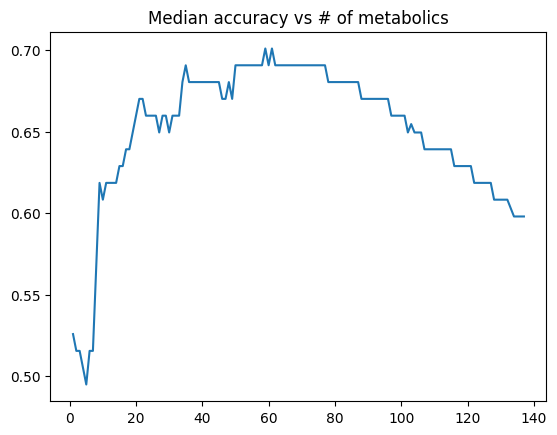

In [8]:
median_accuracy =  []
idx = [x+1 for x in range(len(X.columns))]

for n in range(len(X.columns)):
    n = n + 1
    # print("TOP",n,"METABOLICS")
    topn = coef_summary.head(n).index.values
    X_n = X_metabolics[topn]
    
    seed = 42
    scaler = StandardScaler()
    count = 0
    saved_model = None
    prev_acc = 0
    accuracy_list = []
    coef_list = []
    
    while (count < 500):
        # if (count % 1000 == 0):
        #     print(count)
        count += 1
        X_train, X_test, y_train, y_test = train_test_split(X_n, y, test_size=0.3, random_state=count)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        model = LinearSVC(random_state=0, max_iter=5000)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracy_list.append(acc)
        coef_list.append(model.coef_[0])

        if (acc > prev_acc):
            saved_model = model
            prev_acc = acc
            # print("Models evaluated:", count)
            # print("Accuracy:", accuracy_score(y_test, y_pred))
            # print("\nClassification Report:\n", classification_report(y_test, y_pred))
            
    
    median_accuracy.append(np.median(accuracy_list))
    # plt.figure(figsize=(8,5))
    # plt.hist(accuracy_list, bins=20, edgecolor='k', alpha=0.7)
    # plt.xlabel("Accuracy")
    # plt.ylabel("Frequency")
    # plt.title("Distribution of Accuracy Scores with top " + str(n) + " metabolics")
    # plt.show()

plt.plot(idx, median_accuracy)
plt.title("Median accuracy vs # of metabolics")
plt.show()